File prods_op_mogreps-uk_20130101_03_00_003.nc already exists.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


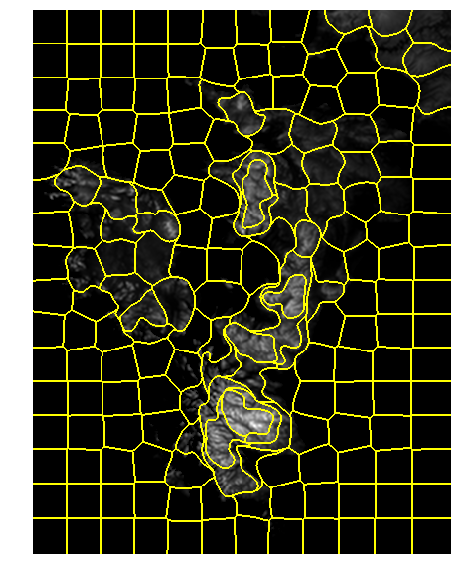

In [6]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse

import mogreps
import netCDF4
from pathlib import Path
#(module for transforming coordinate systems)
import cartopy.crs as ccrs

#from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)

import numpy as np


def Super_Pixel(dataset, split_variables, numSegments):
    """
    Splits the domain into super pixels given one data set and the names of 3 variables to split on and the number of superpixels. 
    """
    image = np.zeros((548,421,3))
    image[:,:,0] = np.array(split_variables[0])
    image[:,:,1] = np.array(split_variables[1])
    image[:,:,2] = np.array(split_variables[2])
    
    #Values need to be normalised between [-1, 1]
    scale = np.max(np.abs(image))
    image = image/scale
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 5)
    
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()
    
    return segments
    
f = mogreps.download_data(
    'mogreps-uk',
    mogreps.make_data_object_name('mogreps-uk', 2013, 1, 1, 3, 0, 3),
    data_folder=mogreps.Path('.'))
    
data_set = netCDF4.Dataset(f)
split_variables=[]
split_variables.append(data_set.variables['surface_altitude'])
split_variables.append(data_set.variables['surface_altitude'])
split_variables.append(data_set.variables['surface_altitude'])
#print(split_variables.shape)

segments = Super_Pixel(data_set, split_variables, 200)

In [77]:
def Month_Map(month_str) : 

    """
    Function to converty months as 3 letter strings to
    corresponding int between 0 and 11.
    month_str : str
    """
    
    Month_Dict = { "Jan" : 0,  "Feb" : 1, "Mar" : 2, "Apr" : 3 , "May" : 4, "Jun" : 5, "Jul" : 6 , "Aug" : 7 , "Sep" : 8, "Oct" : 9 , "Nov" : 10 , "Dec" : 11}
    
    return Month_Dict[month_str]


def Pull_Out_Location_Array(variable_list,year,month,day,hour,forecast_period, segments) : 
    
    """
    Function to find the mean and variance of each super pixel across all ensemble members
    """
    
    num_ensemble_members = 12
    
    
    f = mogreps.download_data('mogreps-uk', mogreps.make_data_object_name('mogreps-uk',year,Month_Map(month),day,hour,0,forecast_period),data_folder=Path('.')  )
    data_set = netCDF4.Dataset(f)
    
    var_name_list = []
    dcounter = 0
    for variable_name in variable_list:
            x = data_set.variables[variable_name].shape
            if len(x)==4:
                for a in range(x[0]):
                    for b in range(x[1]):
                        #try:
                            test_var_data = data_set.variables[variable_name][a][b].data
                            test_var_data = np.array(test_var_data)
                            var_name = variable_name + '_' + str(a) + '_' + str(b)
                            var_name_list.append(var_name)
                            dcounter +=1
                        #except:
                        #    print('skipping', variable_name, a, b)
            elif len(x)==3:
                for a in range(x[0]):
                    #try: 
                        test_var_data = data_set.variables[variable_name][a].data
                        test_var_data = np.array(test_var_data)
                        var_name = variable_name + '_' + str(a)
                        var_name_list.append(var_name)
                        dcounter +=1
                    #except:
                    #    print('skipping', variable_name, a)
        
    ens_mean = np.zeros([len(var_name_list),num_ensemble_members, np.max(segments)])
    
    #print(len(var_name_list))
    #print(dcounter)
    
    for i in range(num_ensemble_members) : 
        f = mogreps.download_data('mogreps-uk', mogreps.make_data_object_name('mogreps-uk',year,Month_Map(month),day,hour,i,forecast_period),data_folder=Path('.')  )
        data_set = netCDF4.Dataset(f)
        
        #var_name_list = []
        #Get the data for this ensemble member
        counter = 0
        for variable_name in variable_list:
            x = data_set.variables[variable_name].shape
            if len(x)==4:
                for a in range(x[0]):
                    for b in range(x[1]):
                        #try:
                            var_data = data_set.variables[variable_name][a][b].data
                            #var_name = variable_name + '_' + int2str(a) + '_' + int2str(b)
                            #var_name_list.append()
                            var_data = np.array(var_data)
                            for j in range(np.max(segments)):
                                #print(ens_mean.shape, i, j)
                                # Find the mean for each ensemble member for each superpixel
                                ens_mean[counter,i,j]=np.mean(var_data[segments==j])
                            counter +=1
                        #except:
                        #    print('skipping', variable_name, a, b)
                                    
            elif len(x)==3:
                for a in range(x[0]):
                    #try: 
                        var_data = data_set.variables[variable_name][a].data
                        #var_name = variable_name + '_' + int2str(a)
                        #var_name_list.append()
                        var_data = np.array(var_data)
                        #print(counter, variable_name) 
                        #print(var_name_list[counter])
                        for j in range(np.max(segments)):
                            #print(ens_mean.shape, i, j)
                            # Find the mean for each ensemble member for each superpixel
                            #print(counter, i, j)
                            ens_mean[counter,i,j]=np.mean(var_data[segments==j])
                        counter +=1
                    #except:
                    #        print('skipping', variable_name, a)

    var_mean = np.mean(ens_mean, axis=1)
    var_variance = np.var(ens_mean, axis=1)
    
    # Get an array len(numsegments) which contains the mean or variance of each super pixel across all ensemble members
    
    return var_mean, var_variance, var_name_list #Property_Array


In [85]:
# List of variables to extract mean and variance
var_list = ['wind_speed_of_gust', 'surface_air_pressure', 'air_temperature', 'relative_humidity', 'surface_altitude', 'wind_speed_of_gust']
vmean, vvar, names = Pull_Out_Location_Array(var_list,2013,"May",1,3,3, segments)

File prods_op_mogreps-uk_20130401_03_00_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_00_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_01_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_02_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_03_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_04_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_05_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_06_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_07_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_08_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_09_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_10_003.nc already exists.
File prods_op_mogreps-uk_20130401_03_11_003.nc already exists.


In [86]:
#print(vmean, vvar)
print(vmean.shape, vvar.shape)
print(type(vmean), type(vvar))
print(names)

(26, 191) (26, 191)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
['wind_speed_of_gust_0', 'wind_speed_of_gust_1', 'wind_speed_of_gust_2', 'surface_air_pressure_0', 'surface_air_pressure_1', 'surface_air_pressure_2', 'surface_air_pressure_3', 'air_temperature_0_0', 'air_temperature_0_1', 'air_temperature_1_0', 'air_temperature_1_1', 'air_temperature_2_0', 'air_temperature_2_1', 'air_temperature_3_0', 'air_temperature_3_1', 'relative_humidity_0_0', 'relative_humidity_0_1', 'relative_humidity_1_0', 'relative_humidity_1_1', 'relative_humidity_2_0', 'relative_humidity_2_1', 'relative_humidity_3_0', 'relative_humidity_3_1', 'wind_speed_of_gust_0', 'wind_speed_of_gust_1', 'wind_speed_of_gust_2']


In [72]:
print(vmean, vvar)

[[2.23343695e+01 2.16058429e+01 2.10656538e+01 ... 6.34989544e+00
  8.10522513e+00 8.39199003e+00]
 [2.07451339e+01 2.00628961e+01 1.88258454e+01 ... 6.31323196e+00
  8.21657999e+00 8.21665037e+00]
 [2.03003621e+01 1.96224589e+01 1.85418108e+01 ... 6.62203181e+00
  8.52257697e+00 8.62399093e+00]
 ...
 [9.95780846e+04 9.97694753e+04 9.99431126e+04 ... 1.01774417e+05
  1.01726391e+05 1.01683792e+05]
 [9.96160039e+04 9.97987949e+04 9.99517240e+04 ... 1.01779837e+05
  1.01721177e+05 1.01676432e+05]
 [9.96426673e+04 9.98121582e+04 9.99475573e+04 ... 1.01786008e+05
  1.01723161e+05 1.01678534e+05]] [[1.65836280e+00 8.99595379e-01 6.78667935e-01 ... 2.91050181e+00
  2.75142642e+00 2.58649299e-01]
 [2.66902393e+00 1.93011197e+00 7.94644557e-01 ... 2.54437597e+00
  2.69566698e+00 4.05343210e-01]
 [2.82315264e+00 2.40635584e+00 1.04329949e+00 ... 2.61508355e+00
  2.47886652e+00 5.37792980e-01]
 ...
 [1.27343157e+04 7.84194530e+03 5.22760523e+03 ... 8.97069268e+02
  1.74277322e+03 2.36725141e+03]

In [87]:
 lists = np.random.rand(2,vmean.shape[0],vmean.shape[1])
lists[0]=vmean
lists[1]=vvar
print(lists.shape)  

(2, 26, 191)


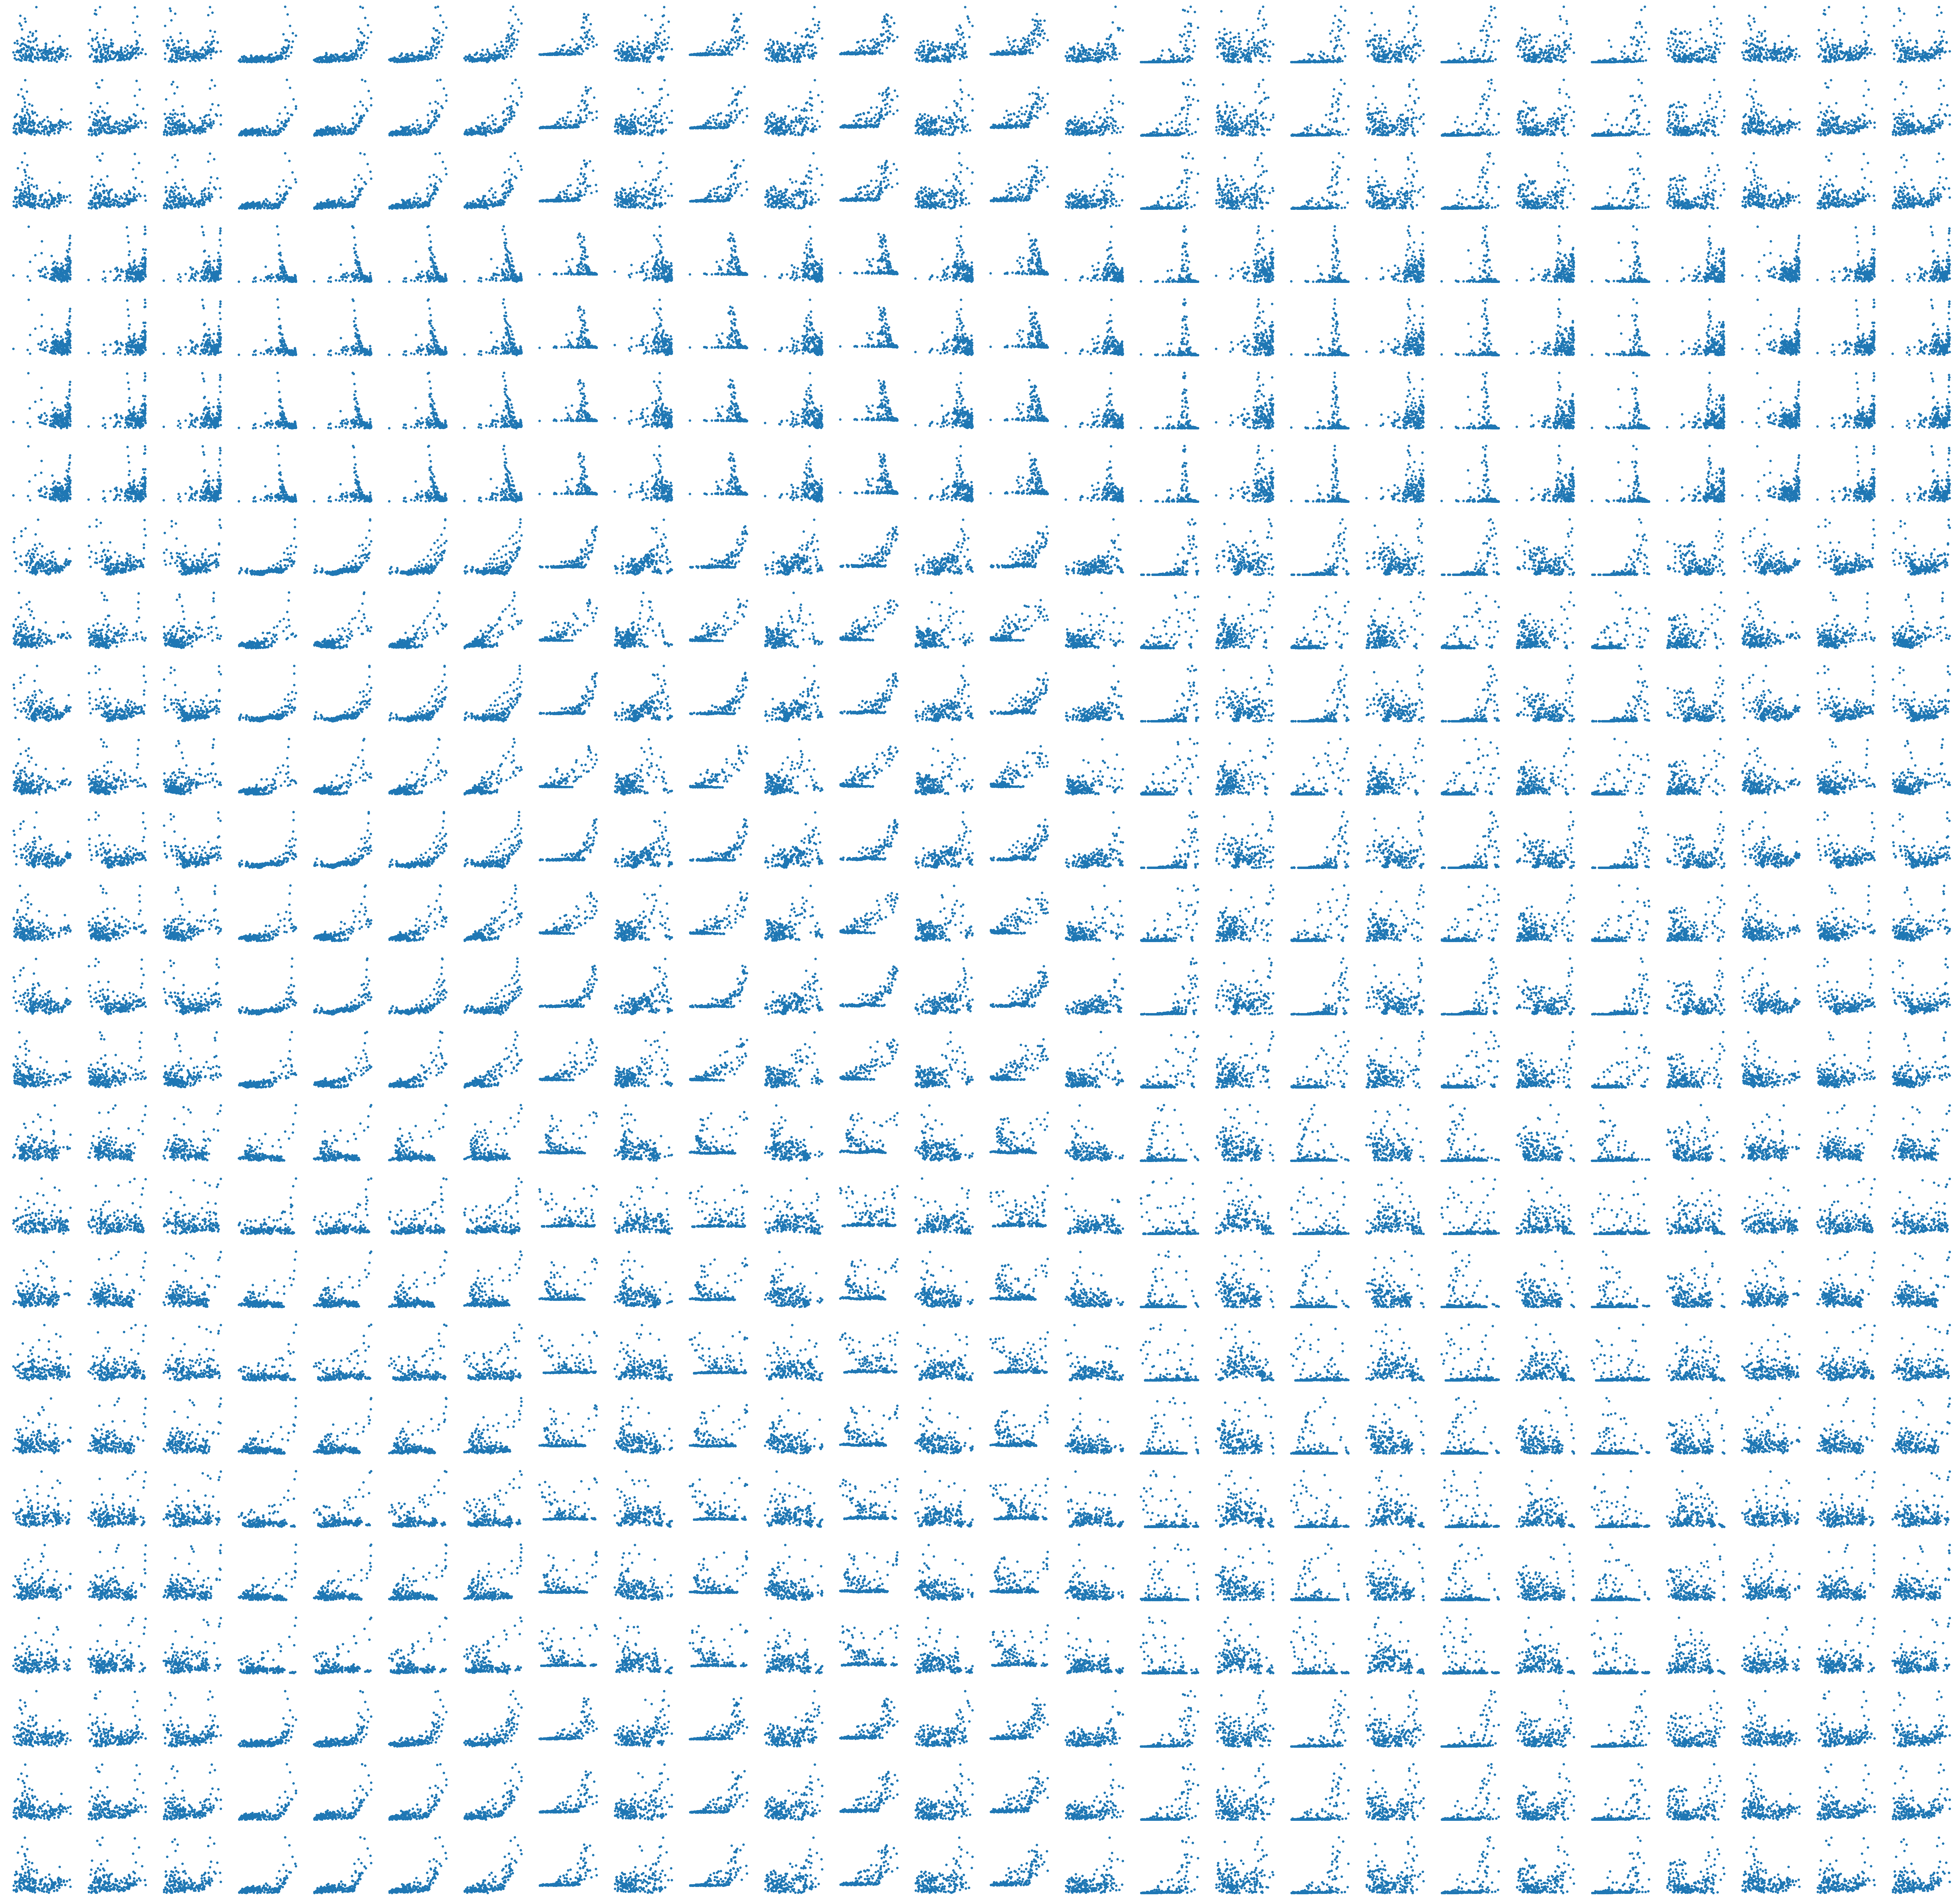

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

#==================================================

# Load list
#lists = np.load('lists.npy')
#lists = np.random.rand(2,3,10)

# lists = [mean or variance, flow property, segment number]

Nv, Np, Ns = np.shape(lists) # Nv = 2 (mean or variance), Np = no of flow properties, Ns = no of segments




# Define width ratio of each subplot
grsp = gs.GridSpec(Np,Np)

plt.figure(figsize=(100,100))
for row in range(0,Np):
    for column in range(0,Np):
        plt.subplot(grsp[row,column])
        plt.scatter(lists[0,row,:],lists[1,column,:])
        plt.axis('off')

['wind_speed_of_gust_0', 'wind_speed_of_gust_1', 'wind_speed_of_gust_2', 'surface_air_pressure_0', 'surface_air_pressure_1', 'surface_air_pressure_2', 'surface_air_pressure_3', 'air_temperature_0_0', 'air_temperature_0_1', 'air_temperature_1_0', 'air_temperature_1_1', 'air_temperature_2_0', 'air_temperature_2_1', 'air_temperature_3_0', 'air_temperature_3_1', 'relative_humidity_0_0', 'relative_humidity_0_1', 'relative_humidity_1_0', 'relative_humidity_1_1', 'relative_humidity_2_0', 'relative_humidity_2_1', 'relative_humidity_3_0', 'relative_humidity_3_1', 'wind_speed_of_gust_0', 'wind_speed_of_gust_1', 'wind_speed_of_gust_2']
26
(2, 26, 191)
(2, 5, 191)
wind_speed_of_gust_0 surface_air_pressure_0 air_temperature_0_0 relative_humidity_0_0 wind_speed_of_gust_0


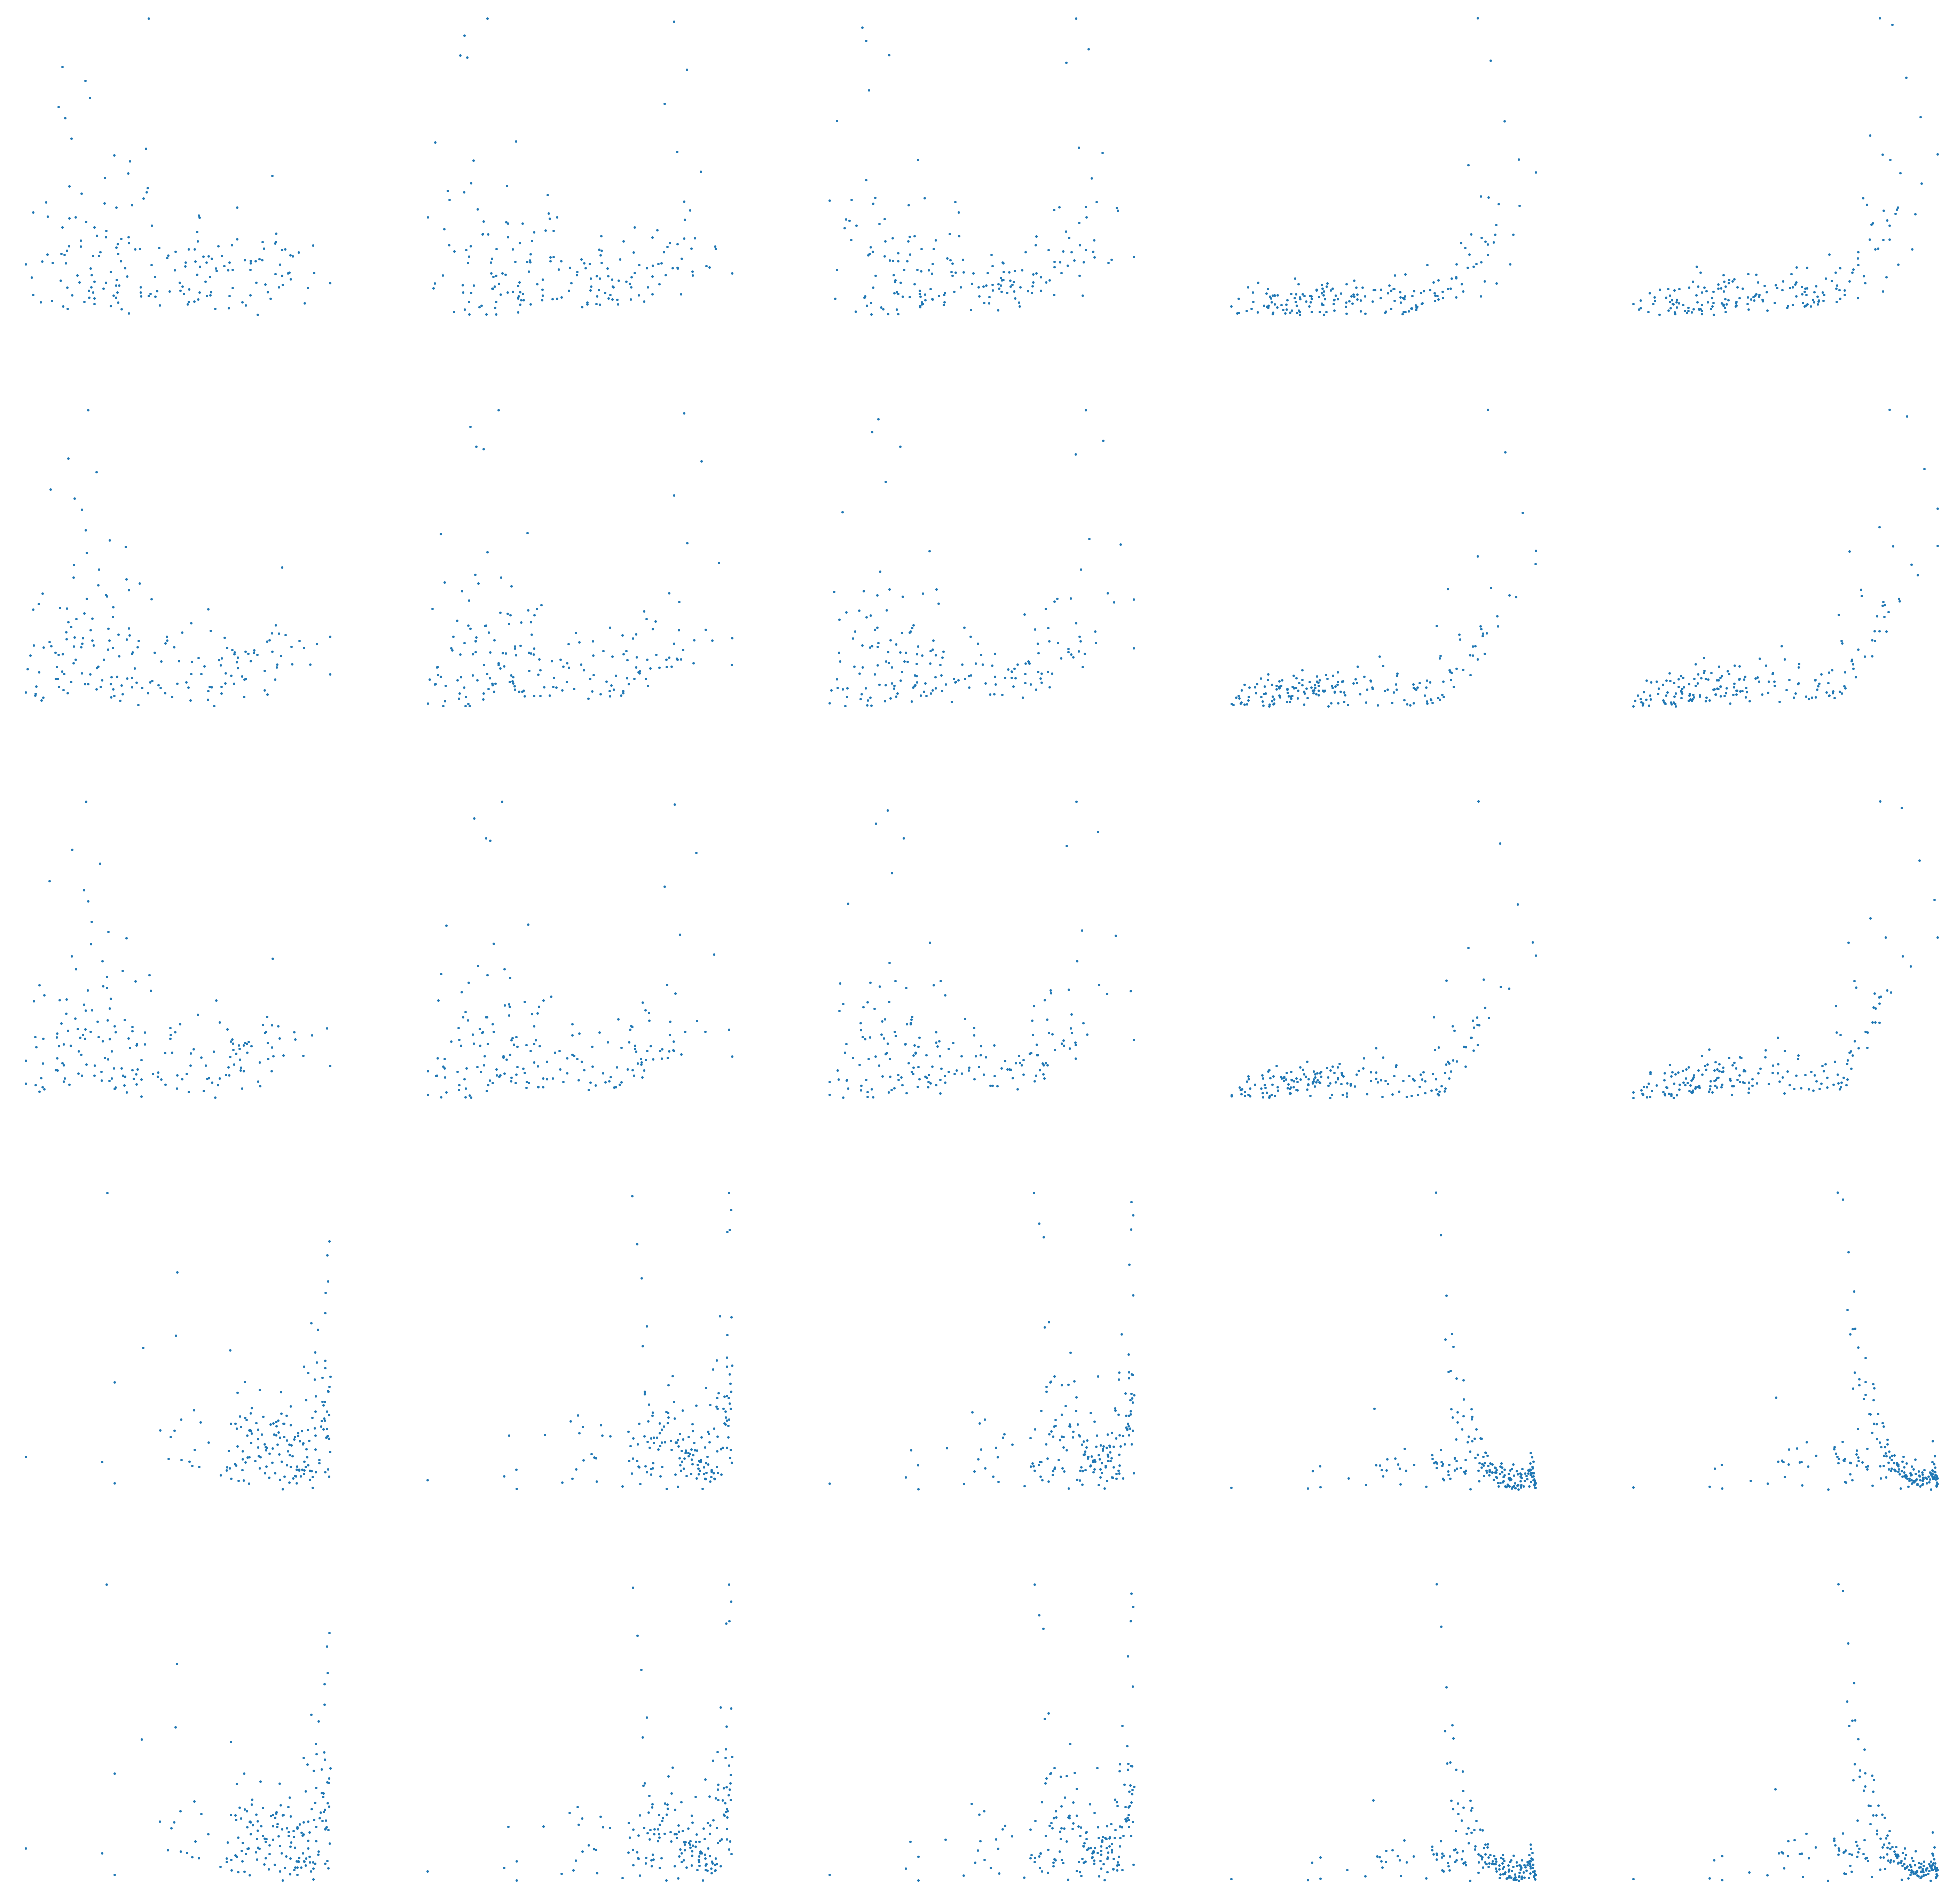

In [102]:
print(names)
print(len(names))
print(lists.shape)
print(lists[:,[0,3, 7, 15, 23],:].shape)
print(names[0], names[3], names[7], names[15], names[23])
shortlist = lists[:,[0,3, 9, 15, 23],:]

Nv, Np, Ns = np.shape(shortlist) # Nv = 2 (mean or variance), Np = no of flow properties, Ns = no of segments

# Define width ratio of each subplot
grsp = gs.GridSpec(Np,Np)

plt.figure(figsize=(100,100))
for row in range(0,Np):
    for column in range(0,Np):
        plt.subplot(grsp[row,column])
        plt.scatter(lists[0,row,:],lists[1,column,:])
        plt.axis('off')